<a href="https://colab.research.google.com/github/nahbos/AUT-Advanced-Information-Retrieval/blob/main/Ex01/traditional_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sobhan Moradian Daghigh

- 11-22-2022

### Ex-01: Traditional methods (WarmUp)

In [90]:
import numpy as np
import pandas as pd
import scipy
import re
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
from collections import Counter
import random
import pickle
from tqdm import tqdm
from PIL import Image

In [91]:
!wget -nc https://raw.githubusercontent.com/nahbos/Advanced-Information-Retrieval/main/Ex01/Data/train_data.csv
!wget -nc https://raw.githubusercontent.com/nahbos/Advanced-Information-Retrieval/main/Ex01/Data/valid_data.csv
!wget -nc https://raw.githubusercontent.com/nahbos/Advanced-Information-Retrieval/main/Ex01/Data/test_data.csv
!wget -nc https://raw.githubusercontent.com/nahbos/Advanced-Information-Retrieval/main/Ex01/Data/bigram_LM.png
!wget -nc https://raw.githubusercontent.com/nahbos/Advanced-Information-Retrieval/main/Ex01/Data/diricklet_smoothing_LM.png

File ‘train_data.csv’ already there; not retrieving.

File ‘valid_data.csv’ already there; not retrieving.

File ‘test_data.csv’ already there; not retrieving.

File ‘bigram_LM.png’ already there; not retrieving.

File ‘diricklet_smoothing_LM.png’ already there; not retrieving.



# Part One. 
* Data Loading

In [92]:
train = pd.read_csv('./train_data.csv')
val   = pd.read_csv('./valid_data.csv')
test  = pd.read_csv('./test_data.csv')

In [93]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,14,29,30,What are the laws to change your status from a...,What are the laws to change your status from a...,0
1,18,37,38,Why are so many Quora users posting questions ...,Why do people ask Quora questions which can be...,1
2,38,77,78,How do we prepare for UPSC?,How do I prepare for civil service?,1
3,58,117,118,I was suddenly logged off Gmail. I can't remem...,I can't remember my Gmail password or my recov...,1
4,60,121,122,How do I download content from a kickass torre...,Is Kickass Torrents trustworthy?,0


In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37250 entries, 0 to 37249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            37250 non-null  int64 
 1   qid1          37250 non-null  int64 
 2   qid2          37250 non-null  int64 
 3   question1     37250 non-null  object
 4   question2     37250 non-null  object
 5   is_duplicate  37250 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.7+ MB


In [95]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1010 non-null   int64 
 1   qid1          1010 non-null   int64 
 2   qid2          1010 non-null   int64 
 3   question1     1010 non-null   object
 4   question2     1010 non-null   object
 5   is_duplicate  1010 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.5+ KB


In [96]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            980 non-null    int64 
 1   qid1          980 non-null    int64 
 2   qid2          980 non-null    int64 
 3   question1     980 non-null    object
 4   question2     980 non-null    object
 5   is_duplicate  980 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 46.1+ KB


## Preprocess

In [97]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953

    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [98]:
train_org = train.copy()
train['question1'] = train['question1'].apply(preprocess)
train['question2'] = train['question2'].apply(preprocess)

val_org = val.copy()
val['question1'] = val['question1'].apply(preprocess)
val['question2'] = val['question2'].apply(preprocess)

test_org = test.copy()
test['question1'] = test['question1'].apply(preprocess)
test['question2'] = test['question2'].apply(preprocess)

**Ok, Everything looks right ))**

# Part Two.
* Vector Space Retrieval

In [99]:
dataset = train

# Dictionary length
#     - with    stop words: 9335
#     - without stop words: 9284

tokenized_qs = [simple_preprocess(remove_stopwords(q)) for q in dataset.loc[:, 'question2']]
dct = Dictionary(tokenized_qs)  # fit dictionary
corpus = [dct.doc2bow(tokenized_q) for tokenized_q in tokenized_qs]  # convert corpus to BoW format

In [100]:
model = TfidfModel(corpus)        # fit model
tfidf_vector = model[corpus]      # apply model to the all corpus document

for question in tfidf_vector[:20]:
   print([[dct[id], round(freq, 2)] for id, freq in question])

[['card', 0.24], ['change', 0.23], ['compare', 0.16], ['green', 0.24], ['immigration', 0.38], ['japan', 0.28], ['laws', 0.59], ['status', 0.29], ['student', 0.26], ['visa', 0.3]]
[['answered', 0.51], ['ask', 0.38], ['easily', 0.42], ['google', 0.4], ['people', 0.28], ['questions', 0.33], ['quora', 0.26]]
[['civil', 0.63], ['prepare', 0.5], ['service', 0.59]]
[['email', 0.34], ['gmail', 0.33], ['mail', 0.43], ['password', 0.32], ['recover', 0.38], ['recovery', 0.4], ['remember', 0.42]]
[['kickass', 0.55], ['torrents', 0.5], ['trustworthy', 0.67]]
[['bad', 0.43], ['book', 0.36], ['new', 0.26], ['rowling', 0.79]]
[['english', 0.37], ['fluently', 0.63], ['learn', 0.43], ['speak', 0.54]]
[['actually', 0.55], ['life', 0.69], ['purpose', 0.47]]
[['compare', 0.2], ['cambodia', 0.29], ['earthquake', 0.58], ['effects', 0.53], ['major', 0.26], ['valparaiso', 0.44]]
[['india', 0.3], ['nuclear', 0.71], ['pakistan', 0.49], ['war', 0.41]]
[['ask', 0.36], ['getting', 0.51], ['improve', 0.3], ['marked'

**Since the Gensim dosent support for max_features, so for rest of the implementation, Im gonna use sklearn instead.**


In [101]:
tr_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
tfidf_matrix_train = tr_vectorizer.fit_transform(train.loc[:, 'question2'])
print(tfidf_matrix_train.shape)

(37250, 2000)


In [102]:
ts_vectorizer = TfidfVectorizer(vocabulary=tr_vectorizer.vocabulary_, stop_words='english')
tfidf_matrix_test = ts_vectorizer.fit_transform(test.loc[:, 'question1'])
print(tfidf_matrix_test.shape)

(980, 2000)


In [103]:
similarity = cosine_similarity(tfidf_matrix_test, tfidf_matrix_train)
similarity.shape

(980, 37250)

In [210]:
def get_similar_questions(test_data, train_data, similarity_matrix, n_sim=10):
    query_resullts = []
    for i, test_q in enumerate(similarity_matrix):
        check_duplicated_qs = []
        bests = np.argsort(test_q.tolist())[::-1]
        for best in bests:
            q = train_org.loc[best, 'question2']
            if q not in check_duplicated_qs:
                check_duplicated_qs.append(q)
                if len(check_duplicated_qs) == n_sim:
                    query_resullts.append(check_duplicated_qs)
                    break
    return query_resullts

In [211]:
random.seed(2)
random_tests = random.sample(range(0, len(test)), 5)
results = get_similar_questions(test, train, similarity)
for i, ele in enumerate(results):
    if i in random_tests:
        print('\n-', test_org.loc[i, 'question1'])
        [print('  > ', q) for q in ele]


- Who will win the election in united states?
  >  Who will win the 2016 United States Presidential election: Trump or Clinton?
  >  Who is the coolest First Lady of the United States?
  >  Who will win the US election?
  >  Who will win Uttar Pradesh election?
  >  Who should be the next President of The United States?
  >  Who do you think will win the U.S. election in November?
  >  Who will win the US election in 2016?
  >  Does the President of the United States have a food taster?
  >  Who will win 2017 Uttar Pradesh Election and why?
  >  Who will win up 2017 election?

- How do I recover my Gmail account when it does not open after password reset?
  >  How can I recover my Gmail account's password?
  >  How do you recover your gmail account password?
  >  How do I reset my Gmail account password?
  >  How can I reset the password for my Gmail account?
  >  How do I recover my Gmail password?
  >  How can you recover your Gmail password?
  >  How Can You Recover Your Gmail Pass

# Part Three.
* Language Model Retrieval

### Unigram

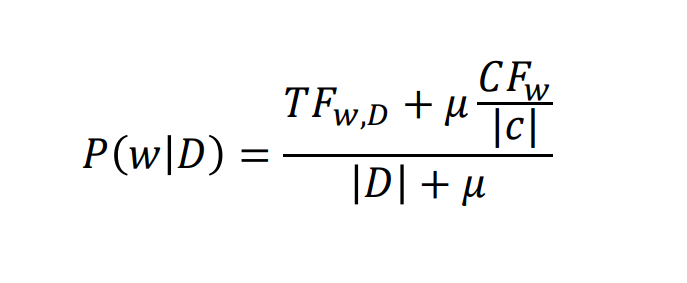

In [106]:
Image.open('./diricklet_smoothing_LM.png')

That id equal to:

(N / (N + mu)) * (TFw,D / |D|) + (mu / (N + mu)) * (CFw / |c|)


In [107]:
def probability_word_given_doc(word, doc, collection, collection_length, collection_freq, mu=10):
    doc_tf = doc.count(word)
    document_length = max(len(doc.split()), 1)
    collection_tf = int(collection_freq.get(word) or 0)

    return np.add(np.multiply(np.divide(document_length, np.add(document_length, mu)), 
                              np.divide(doc_tf, document_length)), 
                  np.multiply(np.divide(mu, np.add(document_length, mu)), 
                              np.divide(collection_tf, collection_length)))

In [179]:
# Reduce the size of datasets by extracting the unique questions
def extract_uniques(dataset, tokenized_dataset, col):
    uniques = dataset.loc[:, col].unique()
    tokenized_uniques = []
    checked = []
    for i, temp in enumerate(list(dataset.loc[:, col])):
        if temp in uniques:
            if temp not in checked:
                checked.append(temp)
                temp2 = tokenized_dataset.loc[:, col][i]
                tokenized_uniques.append(temp2)
    return tokenized_uniques

In [183]:
tokenized_uniques_train = extract_uniques(dataset=train_org, tokenized_dataset=train, col='question2')
tokenized_uniques_val = extract_uniques(dataset=val_org, tokenized_dataset=val, col='question1')
tokenized_uniques_test = extract_uniques(dataset=test_org, tokenized_dataset=test, col='question1')

In [185]:
tokenized_qs_train = [simple_preprocess(remove_stopwords(q)) for q in tokenized_uniques_train]
tokenized_qs_val   = [simple_preprocess(remove_stopwords(q)) for q in tokenized_uniques_val]

collection = ' '.join(' '.join(ele) for ele in tokenized_qs_train)  # Stop words removed
collection_freq = dict(Counter(collection.split()))
collection_length = len(collection_freq)

In [187]:
def get_relevants(dataset, q1):
    groups = dataset.groupby(by='question1')
    for grp, pdf in groups:
        if grp == q1:
            return list(pdf.loc[:, 'question2'])

In [188]:
for i, val_q in enumerate(tokenized_qs_val[:3]):
    scores = []
    for train_q in tqdm(tokenized_qs_train):
        prob = 1
        for token in val_q:
            prob = np.multiply(prob, probability_word_given_doc(word=token, doc=' '.join(train_q), collection=collection, collection_length=collection_length, collection_freq=collection_freq))
        scores.append(prob)

    print('\nValidation Q1: ', val_org.loc[:, 'question1'].unique()[i])
    
    relevant_qs = get_relevants(val_org, q1=val_org.loc[:, 'question1'].unique()[i])
    print('Relevants    : ', )
    [print('             > ', q) for q in relevant_qs]

    print('Train Q2     :')
    [print('             > ', q) for q in list(train_org.loc[:, 'question2'].unique()[np.argsort(scores)[::-1][:5]])]
    print()

100%|██████████| 16658/16658 [00:04<00:00, 3377.30it/s]



Validation Q1:  Realistically speaking, what would happen to the USA if Donald Trump wins Presidency in the 2016 elections?
Relevants    : 
             >  Why is Donald Trump supported so much? What will happen if he wins the election?
             >  If Donald Trump wins presidential election, what will happen?
             >  What's going to happen to America if Donald Trump wins?
             >  What will happen to America if Donald Trump wins the election?
             >  What will happen to the superpower status of the USA, if Donald Trump wins the 2016 Presidential elections?
             >  What will happen to the economy as a whole if Donald Trump wins the presidential election?
             >  What will happen if Donald Trump gets elected?
Train Q2     :
             >  What will happen to the superpower status of the USA, if Donald Trump wins the 2016 Presidential elections?
             >  If Donald Trump wins, what will happen?
             >  How will India's relation wi

100%|██████████| 16658/16658 [00:01<00:00, 14996.96it/s]



Validation Q1:  Does global warming exist?
Relevants    : 
             >  Is the global warming climate change things for real or a hoax?
             >  Is it possible that global warming is a hoax?
             >  Is Global warming real or a hoax?
             >  Is global warming a hoax?
Train Q2     :
             >  Was global warming replaced by climate change because they found there was no global warming?
             >  Why don't we stop global warming?
             >  Is global warming a hoax?
             >  Can we stop global warming? Yeo/No? Why?
             >  Is Global warming real or a hoax?



100%|██████████| 16658/16658 [00:01<00:00, 15176.31it/s]



Validation Q1:  How do I make India as corruption free?
Relevants    : 
             >  What steps must Indians take to make India corruption free?
             >  What if India becomes corruption free?
             >  Can India be a corruption free country?
             >  What steps can be taken to make Municipal Corporations more efficient and corruption free?
Train Q2     :
             >  What steps must Indians take to make India corruption free?
             >  What if India becomes corruption free?
             >  What I can do for corruption free India?
             >  How will be corruption free India?
             >  Can India be a corruption free country?



## Bigram

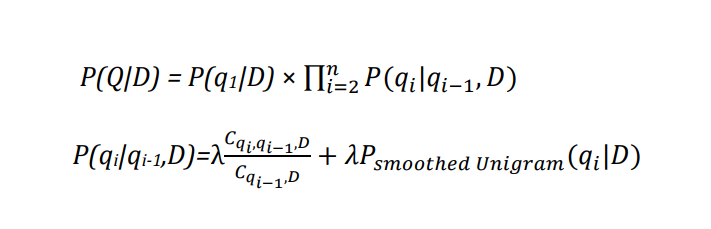

In [33]:
Image.open('./bigram_LM.png')

In [267]:
def probability_bigram_word_given_doc(curr_word, last_word, doc, collection, collection_length, collection_freq, _lambda=100):
    doc_tf = doc.count(curr_word + ' ' + last_word)
    doc_tf_last_word = max(doc.count(last_word), 1)
    prob_smoothed_unigram = probability_word_given_doc(word=curr_word, doc=doc, collection=collection, collection_length=collection_length, collection_freq=collection_freq, mu=100) # P(qi|D)

    return np.add(np.multiply(_lambda, np.divide(doc_tf, doc_tf_last_word)), 
                  np.multiply((1 - _lambda), prob_smoothed_unigram))

In [268]:
for i, val_q in enumerate(tokenized_qs_val[:7]):
    scores = []
    for train_q in tqdm(tokenized_qs_train):
        prob = probability_word_given_doc(word=val_q[0], doc=' '.join(train_q), collection=collection, collection_length=collection_length, collection_freq=collection_freq, mu=100) # P(q1|D)
        last_token = val_q[0]
        for token in val_q[1:]:
            temp = probability_bigram_word_given_doc(curr_word=token, last_word=last_token, doc=' '.join(train_q), collection=collection, collection_length=collection_length, collection_freq=collection_freq, _lambda=100)
            prob = np.multiply(prob, temp)
            last_token = token
        scores.append(prob)

    print('\nValidation Q1: ', val_org.loc[:, 'question1'].unique()[i])
    
    relevant_qs = get_relevants(val_org, q1=val_org.loc[:, 'question1'].unique()[i])
    print('Relevants    : ', )
    [print('             > ', q) for q in relevant_qs]

    print('Train        :')
    [print('             > ', q) for q in list(train_org.loc[:, 'question2'].unique()[np.argsort(scores)[::-1][:5]])]
    print()

100%|██████████| 16658/16658 [00:04<00:00, 3548.95it/s]



Validation Q1:  Realistically speaking, what would happen to the USA if Donald Trump wins Presidency in the 2016 elections?
Relevants    : 
             >  Why is Donald Trump supported so much? What will happen if he wins the election?
             >  If Donald Trump wins presidential election, what will happen?
             >  What's going to happen to America if Donald Trump wins?
             >  What will happen to America if Donald Trump wins the election?
             >  What will happen to the superpower status of the USA, if Donald Trump wins the 2016 Presidential elections?
             >  What will happen to the economy as a whole if Donald Trump wins the presidential election?
             >  What will happen if Donald Trump gets elected?
Train        :
             >  What will happen to the superpower status of the USA, if Donald Trump wins the 2016 Presidential elections?
             >  Is Donald Trump making campaign promises that he can't realistically keep?
         

100%|██████████| 16658/16658 [00:01<00:00, 11799.37it/s]



Validation Q1:  Does global warming exist?
Relevants    : 
             >  Is the global warming climate change things for real or a hoax?
             >  Is it possible that global warming is a hoax?
             >  Is Global warming real or a hoax?
             >  Is global warming a hoax?
Train        :
             >  Was global warming replaced by climate change because they found there was no global warming?
             >  Why don't we stop global warming?
             >  Is global warming a hoax?
             >  Can we stop global warming? Yeo/No? Why?
             >  Is Global warming real or a hoax?



100%|██████████| 16658/16658 [00:01<00:00, 11640.45it/s]



Validation Q1:  How do I make India as corruption free?
Relevants    : 
             >  What steps must Indians take to make India corruption free?
             >  What if India becomes corruption free?
             >  Can India be a corruption free country?
             >  What steps can be taken to make Municipal Corporations more efficient and corruption free?
Train        :
             >  What steps must Indians take to make India corruption free?
             >  How will be corruption free India?
             >  What I can do for corruption free India?
             >  What if India becomes corruption free?
             >  Can India be a corruption free country?



100%|██████████| 16658/16658 [00:01<00:00, 8376.36it/s]



Validation Q1:  What is the one thing that you would like to do if you had an unlimited amount of money?
Relevants    : 
             >  If you had an unlimited amount of money, what would you do with your life?
             >  What would you do if you had an unlimited source of wealth?
             >  What would you do if you had an unlimited amount of money? (No limits, so let your imagination run wild!)
             >  What would you do with your life if you had an unlimited supply of friends and money?
             >  If you had unlimited money and time, what would you do and why?
Train        :
             >  Foreign students pay more for an English university education. Why don't English universities help poor foreign students by halving fees and doubling the number of foreign students? And shouldn't a higher percentage of foreign students be non-white?
             >  I have got fake currency notes from shop 2-3 times in India? Can I convert it to a good currency note in the b

100%|██████████| 16658/16658 [00:01<00:00, 8394.40it/s]



Validation Q1:  How do I stop my addiction to porn and masturbation?
Relevants    : 
             >  How do I stop addiction to porn?
             >  How can I stop my porn addiction?
             >  How can I drop porn and masturbation?
Train        :
             >  Will masturbation without porn help me to overcome my addiction to porn, or is it better not to masturbate at all?
             >  How can I stop my porn addiction?
             >  How do I get over my porn addiction?
             >  How do I get rid off from porn addiction?
             >  How did you overcome porn addiction?



100%|██████████| 16658/16658 [00:05<00:00, 3211.98it/s]



Validation Q1:  Why does Quora succeed in spite of having some other Q and A websites like Yahoo Answers and Wiki Answers?
Relevants    : 
             >  How has Quora succeeded where websites such as Yahoo and Reddit have failed?
             >  How did Quora managed to be a success, where earlier public QA forum failed to do that, like wiki and yahoo answers?
             >  Why will Quora succeed in a space where Google and Yahoo answers has not?
             >  Why did Yahoo answers fail and Quora succeed?
Train        :
             >  Why do so many people ask questions on Quora instead of searching the answers on Wikipedia?
             >  I am a 23-year-old girl working in a reputed IT company with a good salary package and easy work-life balance (8 months of work experience). But for the past 2-3 months I am feeling like I am not interested in IT. What options do I have for my career now (work field change/higher studies)?
             >  I am unable to upload pictures on In

100%|██████████| 16658/16658 [00:00<00:00, 18530.04it/s]



Validation Q1:  What are your paranormal experiences?
Relevants    : 
             >  What are some paranormal experiences you had?
             >  Have you ever experienced any paranormal activities?
             >  Have you ever had any paranormal experience?
             >  What are the creepiest paranormal experience you have had?
Train        :
             >  I am a 23-year-old girl working in a reputed IT company with a good salary package and easy work-life balance (8 months of work experience). But for the past 2-3 months I am feeling like I am not interested in IT. What options do I have for my career now (work field change/higher studies)?
             >  Foreign students pay more for an English university education. Why don't English universities help poor foreign students by halving fees and doubling the number of foreign students? And shouldn't a higher percentage of foreign students be non-white?
             >  I am unable to upload pictures on Instagram. When I take a

# Part Four.
* Evaluation Metrics

In [36]:
groups = test_org.groupby(by='question1')
groups.first()

,id,qid1,qid2,question2,is_duplicate
question1,,,,,
Can Donald Trump really become President of US?,38545,69984,69985,What are the chances that Donald Trump will be...,1
Can I grow height after 19 years?,98278,149375,157481,Is it possible to increase your height after 19?,1
Can I locate someones phone without them knowing or having apps?,51470,91290,52786,How can I locate a cell phone location?,1
Can I sell my business idea?,107485,175643,112223,Where can I sell my idea?,1
Can we expect time travel to become a reality?,21100,39755,1183,Do you think time travel is possible?,1
...,...,...,...,...,...
Why do people still think the the world is flat?,4014,7948,7949,Why do some people today still believe that th...,1
Why do some answers collapse in Quora?,8574,4902,16705,Why are some answers collapsed?,1
Why do we fall in love?,98453,163595,136954,"What makes people ""fall"" in love?",1


In [37]:
for i, (grp, pdf) in enumerate(groups):
    print(' > {:65} : # of relevant questions: {}'.format(grp, len(pdf)))
    if i == 5: break

 > Can Donald Trump really become President of US?                   : # of relevant questions: 8
 > Can I grow height after 19 years?                                 : # of relevant questions: 1
 > Can I locate someones phone without them knowing or having apps?  : # of relevant questions: 2
 > Can I sell my business idea?                                      : # of relevant questions: 6
 > Can we expect time travel to become a reality?                    : # of relevant questions: 25
 > Can you help me get a lot more followers on Instagram?            : # of relevant questions: 5


In [38]:
def check_relevancy(groups, query, returned_docs):
    reles = []
    for i, (grp, pdf) in enumerate(groups):
        if grp == query: 
            relevances = [ele for ele in pdf.loc[:, 'question2']]
            for doc in returned_docs:
                if doc in relevances:
                    reles.append(1)
                else: 
                    reles.append(0)
            return reles    # Returns an array like: [0, 1, 1, 0, 0, 1, ...]

### Average Precision (AP)

In [61]:
def eval_AP(arr):
    relevant = 0
    map = 0
    for i, ele in enumerate(arr):
        if ele == 1:
            relevant += 1
            map += relevant / (i + 1)
    return (map / relevant) if relevant != 0 else 0

### Reciprocal Rank (RR)

In [258]:
def eval_RR(arr):
    for i, ele in enumerate(arr):
        if ele == 1:
            return 1 / (i + 1)
    return 0

### Precision @ k

In [262]:
def p_at_k(arr, k=10):
    return sum(arr[:k]) / k

### First algorithm evaluation

In [213]:
results = get_similar_questions(test, train, similarity)

In [264]:
groups_test = test_org.groupby(by='question1')
evals = []
for i, ele in enumerate(results):
    temp = check_relevancy(groups_test, test_org.loc[i, 'question1'], ele)

    eval_ap = eval_AP(temp)
    eval_rr = eval_RR(temp)
    eval_p_at_5 = p_at_k(temp, k=5)
    eval_p_at_10 = p_at_k(temp)


    evals.append([eval_ap, eval_rr, eval_p_at_5, eval_p_at_10])


arrs = np.array(evals).reshape(-1, order='F').reshape(4, -1)
print('MAP : {:.3f}'.format(np.average(arrs[0])))
print('MRR : {:.3f}'.format(np.average(arrs[1])))
print('P@5 : {:.3f}'.format(np.average(arrs[2])))
print('P@10: {:.3f}'.format(np.average(arrs[3])))

MAP : 0.685
MRR : 0.788
P@5 : 0.874
P@10: 0.437


# Find parameters
**Its time to search for best parameters value using evaluation metrics on validation dataset**

In [191]:
groups_val = val_org.groupby(by='question1')

In [197]:
k = 5

In [266]:
for mu in [0, 1, 10, 100]:
    for _lambda in [0.1, 0.5, 0.9]:
        evals = []
        for i, val_q in enumerate(tqdm(tokenized_qs_val[:10])):
            scores = []
            for train_q in tokenized_qs_train:
                prob = probability_word_given_doc(word=val_q[0], doc=' '.join(train_q), collection=collection, collection_length=collection_length, collection_freq=collection_freq, mu=mu) # P(q1|D)
                last_token = val_q[0]
                for token in val_q[1:]:
                    temp = probability_bigram_word_given_doc(curr_word=token, last_word=last_token, doc=' '.join(train_q), collection=collection, collection_length=collection_length, collection_freq=collection_freq, _lambda=_lambda)
                    prob = np.multiply(prob, temp)
                    last_token = token
                scores.append(prob)

            relevante_results = check_relevancy(groups_val, query=val_org.loc[i, 'question1'], returned_docs=list(train_org.loc[:, 'question2'].unique()[np.argsort(scores)[::-1][:k]]))
            eval_ap = eval_AP(relevante_results)
            eval_rr = eval_RR(relevante_results)
            eval_p_at_5 = p_at_k(relevante_results, k=5)
            eval_p_at_10 = p_at_k(relevante_results)
            evals.append([eval_ap, eval_rr, eval_p_at_5, eval_p_at_10])
            
            if i == 7:
                print('\nValidation Q1: ', val_org.loc[:, 'question1'].unique()[i])
                
                relevant_qs = get_relevants(val_org, q1=val_org.loc[:, 'question1'].unique()[i])
                print('Relevants    : ', )
                [print('             > ', q) for q in relevant_qs]

                print('Train        :')
                [print('             > ', q) for q in list(train_org.loc[:, 'question2'].unique()[np.argsort(scores)[::-1][:k]])]

                print('AP: {:.2f}'.format(ap_metric))
                print()

        print('\n---------------------------------------')

        arrs = np.array(evals).reshape(-1, order='F').reshape(4, -1)
        print('MAP : {:.3f}'.format(np.average(arrs[0])))
        print('MRR : {:.3f}'.format(np.average(arrs[1])))
        print('P@5 : {:.3f}'.format(np.average(arrs[2])))
        print('P@10: {:.3f}'.format(np.average(arrs[3])))

 80%|████████  | 8/10 [00:22<00:05,  2.62s/it]


Validation Q1:  How can I stop myself from watching too much of porn?
Relevants    : 
             >  How can I stop watching porn?
             >  How do I stop addiction to porn?
             >  How can I control myself from masturbating while watching porn?
             >  Catholics: how do I stop watching internet porn?
             >  How do I stop being addicted to porn?
             >  What should be done to avoid watching porn?
             >  How do I stop masturbating/watching porn? I can't/don't masturbate without watching porn.
             >  How shall I stop watching porn?
Train        :
             >  How do I stop masturbating/watching porn? I can't/don't masturbate without watching porn.
             >  Should I stop watching porn?
             >  Why can't I stop watching porn?
             >  How can I stop watching porn?
             >  How shall I stop watching porn?
AP: 0.70



100%|██████████| 10/10 [00:28<00:00,  2.87s/it]


---------------------------------------
MAP : 0.437
MRR : 0.442
P@5 : 0.420
P@10: 0.210


### Finito